# Assignment 13 (Building Resnet18 Architecture and getting > 90% Accuracy under 30 epochs )

Executive Summary
--------------------

ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully. Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing gradients.

![](images/imagenet.png)

Input
-------
1) Cifar10 60000 images (10 Class)

2) The Images are already segreegated as Train and Test Data with the respective target values



 Requirement
 -----------
1. Refer to your Assignment 12.
2. Replace whatever model you have there with the ResNet18 model as shown below.
Your model must look like Conv->B1->B2->B3->B4 and not individually called Convs. 
3. If not already using, then:
Use Batch Size 128
4. Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
5. Random Crop of 32 with padding of 4px
6. Horizontal Flip (0.5)
7. Optimizer: SGD, Weight-Decay: 5e-4
8. NOT-OneCycleLR
9. Save model (to drive) after every 50 epochs or best model till now
10. Describe your blocks, and the stride strategy you have picked
11. Train for 300 Epochs
12. Assignment Target Accuracy is 90%, so exit gracefully if you reach 90% (you can target more, it can go till ~93%)

Environment
--------------
 Development - Colab GPU , Jupyter Notebook Repository : Github


About the Assignment
-----------------------
1. Created New Class for Resnet18 Architecture . The class can be modified a bit to handle all other Resnet Architectures.

Here is the diagram I used for building Resnet18 model. As the Image size of Cifar10 is 32 * 32 , hence I didn't use the initial 7 x 7 (Stride-2) and Maxpool layer as that would not allow the netowrk to go deep.

![](images/resnet18.png)

Convolution Layer| Input size| Kernel Size| No of kernels|  Stride   Output size

1st Conv Layer     32 * 32      3 * 3         64              1      32 * 32

2nd Conv Layer     32 * 32      3 * 3         64              1      32 * 32

3rd Conv Layer     32 * 32      3 * 3         64              1      32 * 32

Add1(1st+3rd)      32 * 32                                           32 * 32

4th Conv Layer     32 * 32      3 * 3         64              1      32 * 32

5th Conv Layer     32 * 32      3 * 3         64              1      32 * 32

Add2(Add1+5th)     32 * 32                                           32 * 32



6th Conv Layer     32 * 32      3 * 3         128              2      16 * 16

7th Conv Layer     16 * 16      3 * 3         128              1      16 * 16

1x1 conv layer-1   32 * 32      1 * 1         128              2      16 * 16

Add3(1x1 -1 , 7th) 16 * 16                                            16 * 16

8th Conv Layer     16 * 16      3 * 3         128              1      16 * 16

9th Conv Layer     16 * 16      3 * 3         128              1      16 * 16

Add4(add3 , 9th)   16 * 16                                            16 * 16



10th Conv Layer     16 * 16      3 * 3        256              2      8 * 8

11th Conv Layer     8 * 8        3 * 3        256              1      8 * 8

1x1 conv layer-2    16 * 16      1 * 1        256              2      8 * 8

Add5(1x1 -2 , 11th) 8 * 8                                             8 * 8

12th Conv Layer     8 * 8        3 * 3        256              1      8 * 8

13th Conv Layer     8 * 8        3 * 3        256              1      8 * 8

Add6(add5 , 13th)   8 * 8                                             8 * 8



14th Conv Layer     8 * 8        3 * 3        512              2      4 * 4

15th Conv Layer     4 * 4        3 * 3        512              1      4 * 4

1x1 conv layer-3    8 * 8        1 * 1        512              2      4 * 4

Add7(1x1 -3 , 15th) 4 * 4                                             4 * 4

16th Conv Layer     4 * 4        3 * 3        512              1      4 * 4

17th Conv Layer     4 * 4        3 * 3        512              1      4 * 4

Add68(add7 , 17th)  4 * 4                                             4 * 4


Average Pool        4 * 4        4 * 4        512                     1 * 1

FC-10               1 * 1                     512                     10,


2. Custom Loss Function 
3. OneCycleLR by modifying titu1994's code
4. CLR using https://github.com/joestrummer82 (Implementation of cyclic learning rate from the paper: Smith, Leslie N. "Cyclical learning rates for training neural networks." 2017)





Set the initial hyper parameters 
----------------------------------

In [0]:
batch_size = 128
alpha = 5e-4
epochs = 100
cutout_proba = 0.5
max_erasures_per_image = 1
end_percentage = 0.05
triangle_tilt = 0.9 # This is used only in case of OLR

Imports the necessary Libraries
--------------------------------

In [2]:

import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
% matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score
np.random.seed(2017) 
from keras.preprocessing.image import ImageDataGenerator
%config InlineBackend.figure_format='retina'
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec
from keras.preprocessing import image
import numpy as np
import cv2
import gc
InteractiveShell.ast_node_interactivity = "all"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    add,
    multiply,
    Dropout
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D
#from keras.layers import Activation, Flatten, Dense, Dropout
#from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D
#from keras.layers import Activation, Flatten, Dense, Dropout
from imgaug import augmenters as iaa

Using TensorFlow backend.


Import function for warning 
----------------------------

In [0]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn



define Mean and Standard Deviation for Image Normalization
-------------------------------------------------------------

In [0]:
mu = np.array([0.4914, 0.4822, 0.4465])
sigma = np.array([0.2023, 0.1994, 0.2010])

Define Class for Cifar Data 
----------------------------

1. Method to Load the Cifar Data &  Shuffle the loaded data 
2. Method to Return the labels


In [0]:
from sklearn.utils import shuffle
class cifar_data:
  def get_cifar10_data(preprocess=False):
      (X_train, y_train), (X_test, y_test) = cifar10.load_data()
      num_classes = len(np.unique(y_train))
      X_train, y_train = shuffle(X_train, y_train)
      X_test, y_test = shuffle(X_test, y_test)

      if preprocess:
          X_train = X_train.astype('float32')
          X_test = X_test.astype('float32')
          X_train /= 255
          X_test /= 255

      Y_train = np_utils.to_categorical(y_train, num_classes)
      Y_test = np_utils.to_categorical(y_test, num_classes)
      return X_train, Y_train, X_test, Y_test
  def get_cifar10_labels():
      return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Define Class for the Following methods
1. Cutout
2. Image Normalization
3. Padding
4. Random Crop
5. Function for Executing the above functions sequentially which can be used during image generator function


In [6]:
import numpy as np

class preprocess_data:
  def get_cutout_eraser(proba=1.0, s_l=0.04, s_h=0.06, r_1=0.35, r_2=1 / 0.35,
                        max_erasures_per_image=1, pixel_level=True):
      """
      :param p:
      :param s_l: Minimum Area Proportion of Original that may be cut
      :param s_h: Maximum Area Proportion of Original that may be cut
      :param r_1: Min Aspect Ratio
      :param r_2: Max Aspect Ratio
      :param max_erasures_per_image:
      :param pixel_level:
      :return: Eraser to be used as Preprocessing Function
      """
      assert max_erasures_per_image >= 1

      def eraser(input_img):
          p_1 = np.random.rand()
          if p_1 > proba:
              return input_img
          img_h, img_w, img_c = input_img.shape
          shape = input_img.shape

          v_l = np.min(input_img)
          v_h = np.max(input_img)

          #         mx = np.random.randint(1, max_erasures_per_image + 1)
          mx = max_erasures_per_image
          for i in range(mx):
              while True:
                  s = np.random.uniform(s_l, s_h) * img_h * img_w
                  r = np.random.uniform(r_1, r_2)
                  w = int(np.sqrt(s / r))
                  h = int(np.sqrt(s * r))
                  left = np.random.randint(0, img_w)
                  top = np.random.randint(0, img_h)

                  if left + w <= img_w and top + h <= img_h:
                      break

              if pixel_level:
                  c = np.random.uniform(v_l, v_h, (h, w, img_c))
              else:
                  c = np.random.uniform(v_l, v_h)

              input_img[top:top + h, left:left + w, :] = c

          return input_img

      return eraser



  def normalize_img(img):
    img = img/255
    img = (img - mu)/sigma
    
    return img

  def pad_img(img):
    return np.pad(img, ((4,4),(4,4),(0,0)), mode='constant',)

  def random_crop(x, random_crop_size):
      w, h = x.shape[0], x.shape[1]
      rangew = (w - random_crop_size[0]) // 2
      rangeh = (h - random_crop_size[1]) // 2
      offsetw = 0 if rangew == 0 else np.random.randint(rangew)
      offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
      return x[offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1],:]

  def horizontal_flip(img,flip = 0.5):
    seq = iaa.Sequential([
      iaa.Fliplr(flip) # horizontally flip 50% of the images
    ])
    img = seq(images=img)
    return img

  cutout_fn = get_cutout_eraser(proba=cutout_proba, s_l=0.1, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=max_erasures_per_image, pixel_level=True)



def reg_fn(x):
  x = preprocess_data.pad_img(x)
  x = preprocess_data.random_crop(x,[32,32])
  x = preprocess_data.cutout_fn(x)
  x = preprocess_data.horizontal_flip(x,flip=0.5)
  return x

X_train, Y_train, X_test, Y_test = cifar_data.get_cifar10_data()
classes = cifar_data.get_cifar10_labels()

170500096/170498071 [==============================] - 2s 0us/step


# Model Visualization Methods 

In [0]:
class model_summary_helper:
  def inspect_predictions(score, predictions,labels, classes, print_results=False, plot_results=True):

      test_score = score
      test_predictions = predictions

      test_predictions = np.argmax(test_predictions, axis=1)
      test_predictions = [classes[p] for p in test_predictions]

      y_test = np.argmax(labels, axis=1)
      y_test = [classes[p] for p in y_test]

      test_precision,test_recall,test_f1,test_support = precision_recall_fscore_support(y_test, test_predictions, average=None, labels=classes)

      results = pd.DataFrame({"classes": classes,
                                   "average":[None]*len(test_precision),
                                    "precision": test_precision,
                                    "recall": test_recall,
                                    "support": test_support,
                                    "data_source": ["test"] * len(test_precision)})

      test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(y_test, test_predictions,
                                                                                           average='micro', labels=classes)

      results_test = pd.DataFrame({"classes": [None],
                                   "average":['micro'],
                                    "precision": [test_precision],
                                    "recall": [test_recall],
                                    "support": [test_support],
                                    "data_source": ["test"]})

      results = pd.concat((results,results_test))

      # =======

      test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(y_test, test_predictions,
                                                                                           average='macro',
                                                                                           labels=classes)

      results_test = pd.DataFrame({"classes": [None],
                                   "average": ['macro'],
                                   "precision": [test_precision],
                                   "recall": [test_recall],
                                   "support": [test_support],
                                   "data_source": ["test"]})

      results = pd.concat((results, results_test))

      # ==============
      test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(y_test, test_predictions,
                                                                                           average='weighted',
                                                                                           labels=classes)

      results_test = pd.DataFrame({"classes": [None],
                                   "average": ['weighted'],
                                   "precision": [test_precision],
                                   "recall": [test_recall],
                                   "support": [test_support],
                                   "data_source": ["test"]})

      results = pd.concat((results, results_test))
      cm = confusion_matrix(y_test, test_predictions)
      balanced_accuracy = balanced_accuracy_score(y_test, test_predictions)
      accuracy = accuracy_score(y_test, test_predictions)


      if print_results:
          print(" =-= " * 20)
          print("Score = ", test_score)
          print("Balanced Accuracy = {:2.2f}%, Accuracy = {:2.2f}%".format(balanced_accuracy * 100, accuracy*100))


      if plot_results:
          print()
          plt.figure(figsize=(16,6))
          sns.barplot(x="classes",y="precision",data=results[~pd.isna(results.classes)])
          lower_bound = max(results['precision'].min() - 0.05,0)
          upper_bound = 1.05
          plt.ylim((lower_bound,upper_bound))
          plt.title("Precision per Class")
          plt.show()

          plt.figure(figsize=(16, 6))
          sns.barplot(x="classes", y="recall", data=results[~pd.isna(results.classes)])
          lower_bound = max(results['recall'].min() - 0.05, 0)
          upper_bound = 1.05
          plt.ylim((lower_bound, upper_bound))
          plt.title("Recall per Class")
          plt.show()

          cmap = plt.get_cmap('Blues')
          figsize = 6*int(np.ceil(len(classes)/10))
          fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(figsize,figsize))
          im = ax.imshow(cm, cmap=cmap)  # Plot the confusion matrix

          # Show all ticks
          ax.set_xticks(np.arange(len(cm[0])))
          ax.set_yticks(np.arange(len(cm[1])))

          ax.set_xticklabels(classes)
          ax.set_yticklabels(classes)

          # Label each axis
          ax.set_ylabel("True Label")
          ax.set_xlabel("Predicted label\n\nAccuracy={:2.2f}% ".format(balanced_accuracy * 100))
          plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
          fig.tight_layout()
          ax.set_title("Confusion Matrix")
          thresh = cm.max() / 2
          for i in range(len(cm[0])):
              for j in range(len(cm[1])):
                  text = ax.text(i, j, cm[i, j],ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
          plt.show()

      return test_score,results

  def plot_model_history(model_history, clip_beginning=0):
    fig, axs = plt.subplots(1,2,figsize=(18,6))
    # summarize history for accuracy
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    axs[0].plot(range(clip_beginning+1,len(acc)+1),acc[clip_beginning:])
    axs[0].plot(range(clip_beginning+1,len(val_acc)+1),val_acc[clip_beginning:])
    axs[0].set_title('Model Accuracy: Train = %.3f, Validation = %.3f'%(acc[-1],val_acc[-1]))
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(clip_beginning+1,len(acc)+1),len(acc)/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    axs[1].plot(range(clip_beginning+1,len(loss)+1),loss[clip_beginning:])
    axs[1].plot(range(clip_beginning+1,len(val_loss)+1),val_loss[clip_beginning:])
    axs[1].set_title('Model Loss: Train = %.3f, Validation = %.3f'%(loss[-1],val_loss[-1]))
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(clip_beginning+1,len(loss)+1),len(loss)/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()



Normalize the Images and create Data Generator function for Training data
----------------------------------------------------------------------------


In [0]:

X_train, Y_train, X_test, Y_test = cifar_data.get_cifar10_data()
X_test = np.array(list(map(preprocess_data.normalize_img,X_test)))
X_train = np.array(list(map(preprocess_data.normalize_img,X_train)))
classes = cifar_data.get_cifar10_labels()


#hf= iaa.Fliplr(0.5)



datagen = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,
 #                          preprocessing_function=reg_fn,horizontal_flip=True)
                            preprocessing_function=reg_fn,horizontal_flip=False)
datagen.fit(X_train)

# datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)


# train_iterator = datagen.flow(X_train, Y_train, batch_size=batch_size,shuffle=True)
# _ = next(train_iterator)

Define a class which would help decide the updated Learning Rate and momentum
-----------------------------------------------------------------------------
for One Cycle Learning Rate 
----------------------------

The Assignment Suggests not to use this one , however used to see the result . All the other experiments use Cyclic Learning Rate 


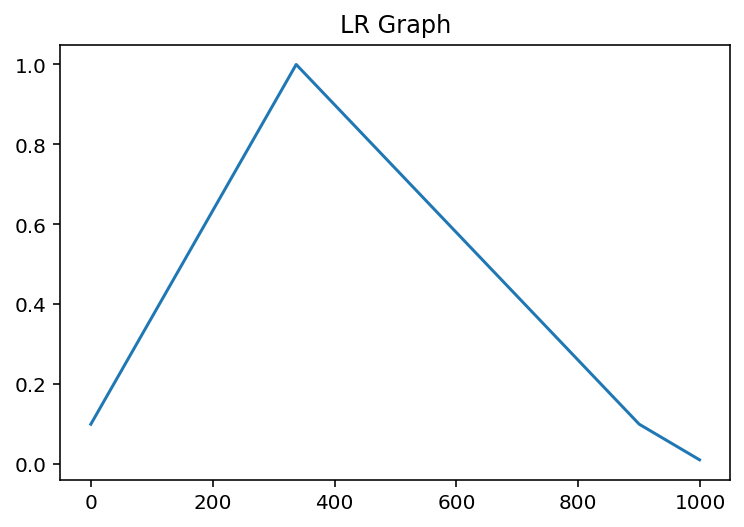

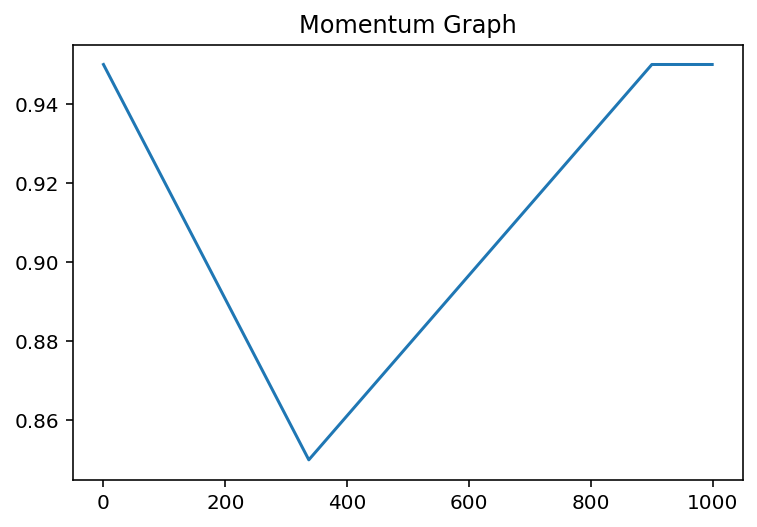

In [0]:
class lr_momentum_decider:
  def min_max_scaler(iterations, num_iterations, end_percentage, min_val, max_val, invert = False, triangle_tilt = 0.75):
    non_slant_mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
    mid_cycle_id = int(triangle_tilt*int(num_iterations * ((1. - end_percentage)) / float(2)))
    value = 0
    if iterations > 2 * non_slant_mid_cycle_id:


        extra_iters = (iterations - 2 * non_slant_mid_cycle_id)
        current_percentage = 1 - (1 - 1/10)*extra_iters/(num_iterations - 2 * non_slant_mid_cycle_id)


    elif iterations >  mid_cycle_id:
        current_percentage = 1. - (iterations - mid_cycle_id) / (2*non_slant_mid_cycle_id - mid_cycle_id)

    else:
        current_percentage = iterations / mid_cycle_id

    if invert:
      if iterations > 2 * non_slant_mid_cycle_id:
        return max_val
      return max_val - current_percentage * (max_val - min_val)
    else:
      if iterations > 2 * non_slant_mid_cycle_id:
        return min_val * current_percentage
      return min_val + current_percentage * (max_val - min_val)



  print("="*80)
  scales = []
  for i in range(1000):
    p = min_max_scaler(i,1000,0.1,min_val=0.1,max_val=1, invert=False)
    scales.append(p)

  plt.plot(np.array(scales))
  plt.title("LR Graph")
  plt.show()

  scales = []
  for i in range(1000):
    p = min_max_scaler(i,1000,0.1,min_val=0.85,max_val=0.95, invert=True)
    scales.append(p)

  plt.plot(np.array(scales))
  plt.title("Momentum Graph")
  plt.show()

## One Cycle LR

In [0]:
import os
import numpy as np
import warnings

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale=100,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 triangle_tilt = 0.75,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")


        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = scale
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = steps
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        new_lr = lr_momentum_decider.min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.initial_lr/self.scale, self.initial_lr, invert = False, triangle_tilt=triangle_tilt)
        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """    
        new_momentum = lr_momentum_decider.min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.min_momentum, self.max_momentum, invert = True, triangle_tilt=triangle_tilt)
        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))
                
    
    def plot(self):
        plt.title("LR-Plot")
        plt.plot(self.history['lr'])
        plt.xlabel("Epochs")
        plt.ylabel("LR")
        plt.show()
        
        plt.title("Momentum-Plot")
        plt.plot(self.history['momentum'])
        plt.xlabel("Epochs")
        plt.ylabel("Momentum")
        plt.show()
        
  

Define Customized Loss Function
--------------------------------

In [0]:
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow_probability as tfp
import tensorflow as tf
class custom_loss:
  
  def get_L2_enhanced_loss(model):
    conv_layers = [layer for layer in model.layers if type(layer)==Convolution2D and layer.trainable_weights[0].shape.as_list()[0]>0]
    conv_layers = conv_layers[:-1]
    def L2_enhanced():
      total_loss = K.variable(0)
      for layer in conv_layers:
        weights = layer.trainable_weights[0]
        total_loss = total_loss + tf.nn.l2_loss(weights)
      return total_loss
    return L2_enhanced



  def get_combined_L2_cross_entropy_loss(model,alpha,batch_size,total_data_size,
                                        epochs, end_percentage=0.1, scale=100):
    l2_loss = custom_loss.get_L2_enhanced_loss(model, )
    iters_per_epoch = int(np.ceil(total_data_size/batch_size))
    num_iterations = epochs*iters_per_epoch
    mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
    container ={"iterations":0}
    sess = K.get_session()



    def combined_loss(y_true, y_pred):
      container['iterations'] = container['iterations'] + 1
      iterations = container['iterations']

      # new_alpha = lr_momentum_decider.min_max_scaler(iterations, num_iterations, end_percentage, alpha/scale, alpha, invert = False)

      new_alpha = alpha

      loss = categorical_crossentropy(y_true, y_pred) + new_alpha * l2_loss()
      return loss
    return combined_loss

Define Custom Function to call back when the validation accuracy reaches the limit 
--------------------------------------------------------------------------------

In [0]:
class StopAtAccValue(Callback):
  def __init__(self,validation_iterator, threshold = 0.9, ):
    super(StopAtAccValue, self).__init__()
    self.threshold = threshold
    self.validation_iterator = validation_iterator
  def on_epoch_end(self, epoch, logs={}):
    score = self.model.evaluate_generator(self.validation_iterator,steps=len(self.validation_iterator))
    acc = score[1]
    if acc >= self.threshold:
      self.model.stop_training = True
      print("Stopping Training:: Val Acc = %.3f Achieved"%(acc))
    else:
      print("Continue Training:: Val Acc = %.3f, Threshold = %.3f"%(acc,self.threshold))
      

In [11]:
gc.collect()

352

Define Resnet Builder Class 
----------------------------

Currently this model defines resnet18 architecture . However this can be used for other resnet blocks .

There are multiple resnet architectures present , however this model is designed for the original one. The model can also be customized for the other architectures as well.

![](images/ra.png)



In [0]:
class build_resnet_model:
  def add_layer(x1,x2):
    return add([x1,x2])

  def identity_block(x,stride=1,n_kernels = 64):

    x = Conv2D(filters=n_kernels, kernel_size=(1, 1),
                               strides=stride,
                               padding='same',
                               kernel_initializer="he_normal",
                               kernel_regularizer=l2(1e-4))(x)


    #x = pre_process(x)
    #x= Activation("relu")(x)
    #x = Dropout(0.1)(x)
    return x


  def norm_conv_layer(x, n_kernels=64, kernel_size=(3,3),dilation_rate=1, border_mode='same',stride=1,first_entry = 'N',first_layer = 'N',first_block = 'N',each_block_length = 2,very_first_block = 'N'):

    if first_entry == 'Y':
      first_layer = 'Y'
    input_data = x

    for i in range(each_block_length):
      if first_entry == 'Y':
        if first_layer == 'Y':
          if first_block == 'Y':
            stride = 1
          else:
            stride = 2
          first_layer = 'N'
        else:
          stride=1
      else:
        stride=1


      x = Conv2D(filters=n_kernels, kernel_size=(3, 3),
                               strides=stride,
                               padding='same',
                               kernel_initializer="he_normal",
                               kernel_regularizer=l2(5e-4))(x)

      if i ==0:
        x = BatchNormalization()(x)
        x= Activation("relu")(x)
      else:
        x = BatchNormalization()(x)
     

    if first_block == 'N' and first_entry == 'Y':

      input_data = build_resnet_model.identity_block(input_data,stride=2,n_kernels= n_kernels)


    if very_first_block == 'N':  
      x = build_resnet_model.add_layer(input_data,x)
      x= Activation("relu")(x)

    return x

  def build_model(inputs,model_type = 'resnet18',num_outputs=10):

    input = inputs

    if model_type == 'resnet18':
      block_type = [2,2,2,2]
      each_block_length = 2
      multiplier = 2
      filter = 64
    x =  build_resnet_model.norm_conv_layer(input, n_kernels=64, kernel_size=(7,7),dilation_rate=1, border_mode='same',stride=1,first_entry = 'N',first_layer = 'N',first_block = 'N',each_block_length = 1,very_first_block = 'Y')


    for block_index,block_length in enumerate(block_type):

      if block_index == 0:
        first_block = 'Y'
      else:
        first_block = 'N'

      for i in range(block_length):
        if i ==0:
          first_entry = 'Y'
        else:
          first_entry = 'N'

        x = build_resnet_model.norm_conv_layer(x, n_kernels=filter, kernel_size=(3,3),dilation_rate=1, border_mode='same',stride=1,first_entry = first_entry,first_layer = 'N',first_block = first_block,each_block_length = 2,very_first_block = 'N')
      print("Filters in Resnet %s = %s, Output Shape = %s"%((i+17),filter, K.int_shape(x)[1:])) 
      # print(" The size of the image after block", block_index +1 , "is", x.shape())

      filter = filter * 2

    pool2 = AveragePooling2D(pool_size=(4,4),
                                   strides=(1, 1))(x)
    flatten1 = Flatten()(pool2)
    dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                        activation="softmax", use_bias=False)(flatten1)
    print("Final Shape ",K.int_shape(dense)[1:])

    model = Model(inputs=input, outputs=dense)
    return model 



Call the build model class to build the model and compile the model 
--------------------------------------------------------------------

In [13]:
inputs = Input(shape=(32,32,3))
model = build_resnet_model.build_model(inputs,model_type = 'resnet18')
optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
model.compile(loss=custom_loss.get_combined_L2_cross_entropy_loss(model,alpha,128,X_train.shape[0], epochs=epochs, end_percentage=end_percentage),
               optimizer=optimizer,
               metrics=['accuracy'])
print("Model Params = ",model.count_params(), ", Metric Names = ",model.metrics_names)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Filters in Resnet 18 = 64, Output Shape = (32, 32, 64)
Filters in Resnet 18 = 128, Output Shape = (16, 16, 128)
Filters in Resnet 18 = 256, Output Shape = (8, 8, 256)
Filters in Resnet 18 = 512, Output Shape = (4, 4, 512)
Final Shape  (10,)
Model Params =  11184768 , Metric Names =  ['loss', 'acc']


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Model Training and Validation
-----------------------------------
1. Define Image Data Generator for Validation
2. Save model checkpoint for best validation accuracy
3. Use the Custom Built Early Stopping function
4. Call Back using check point, Stopper and olr 
5. Plot the Loss, Accuracy and OLR graph

13

Epoch 1/30
 78/391 [====>.........................] - ETA: 30s - loss: 2.2847 - acc: 0.5300 - lr: 0.04812 - momentum: 0.89 
Continue Training:: Val Acc = 0.530, Threshold = 0.900
391/391 [==============================] - 142s 364ms/step - loss: 2.4722 - acc: 0.4647 - val_loss: 2.2894 - val_acc: 0.5297
Epoch 2/30
 78/391 [====>.........................] - ETA: 26s - loss: 2.3495 - acc: 0.5264 - lr: 0.08634 - momentum: 0.88 
Continue Training:: Val Acc = 0.526, Threshold = 0.900
391/391 [==============================] - 121s 310ms/step - loss: 1.9222 - acc: 0.6457 - val_loss: 2.3492 - val_acc: 0.5264
Epoch 3/30
 78/391 [====>.........................] - ETA: 26s - loss: 2.2339 - acc: 0.6204 - lr: 0.12456 - momentum: 0.88 
Continue Training:: Val Acc = 0.620, Threshold = 0.900
391/391 [==============================] - 121s 310ms/step - loss: 1.6720 - acc: 0.7187 - val_loss: 2.2496 - val_acc: 0.6203
Epoch 4/30
 78/391 [====>.........................] - ETA: 26s - loss: 1.5788 - acc: 0.7

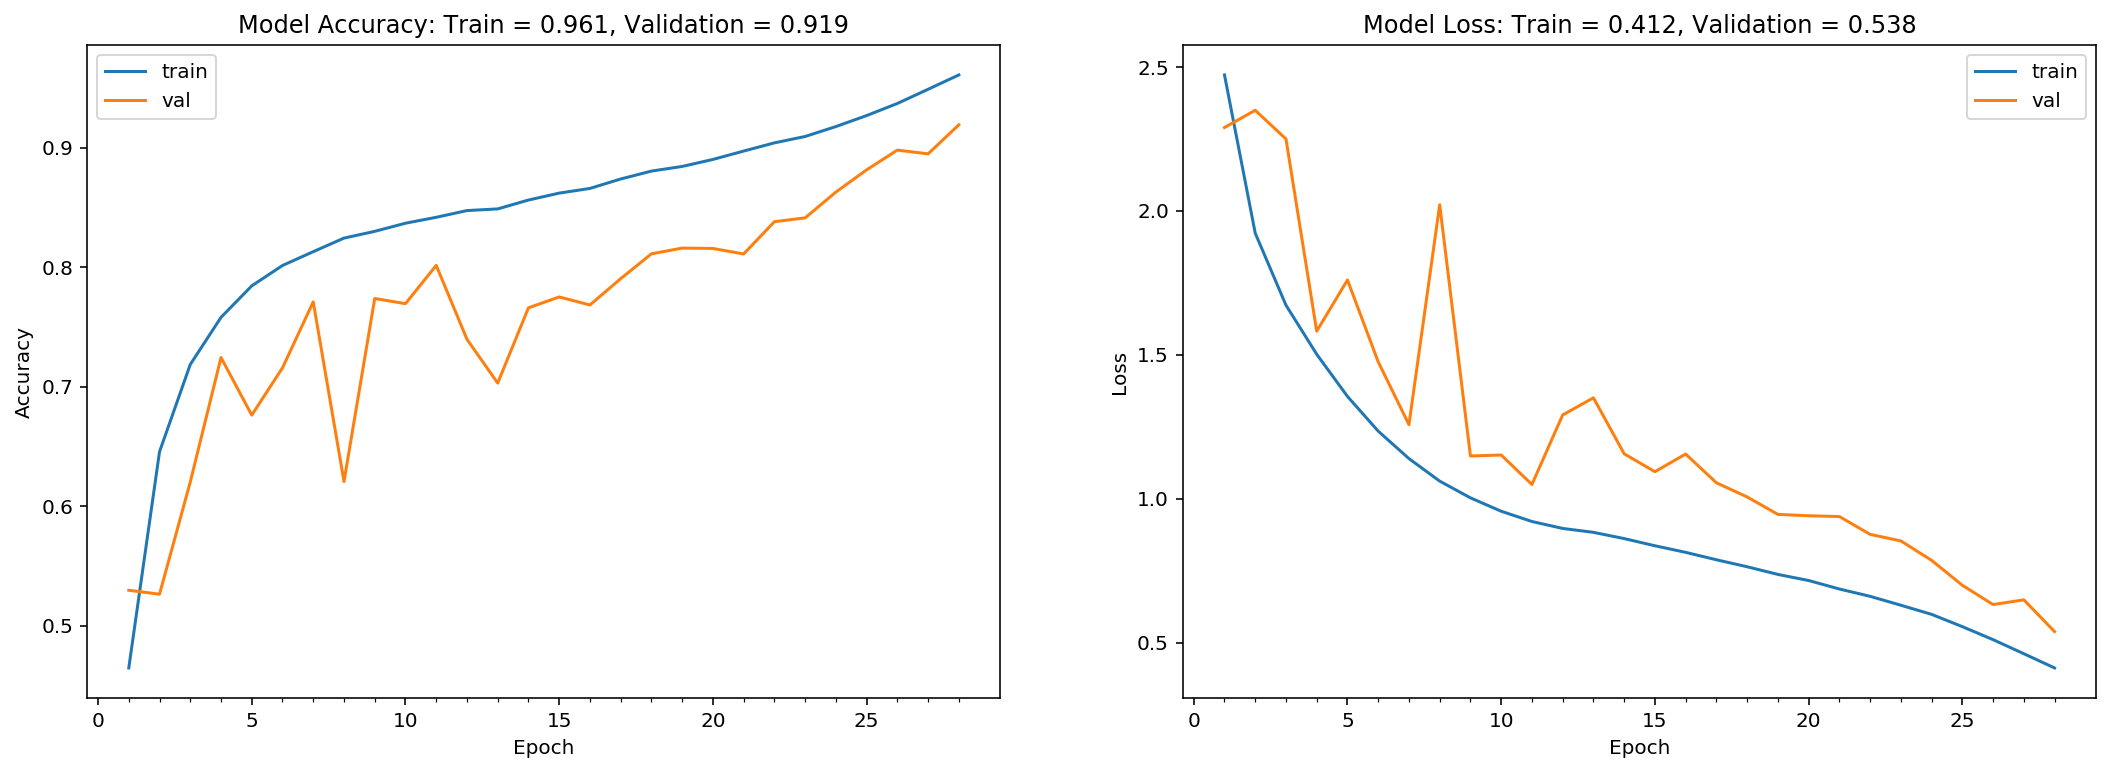

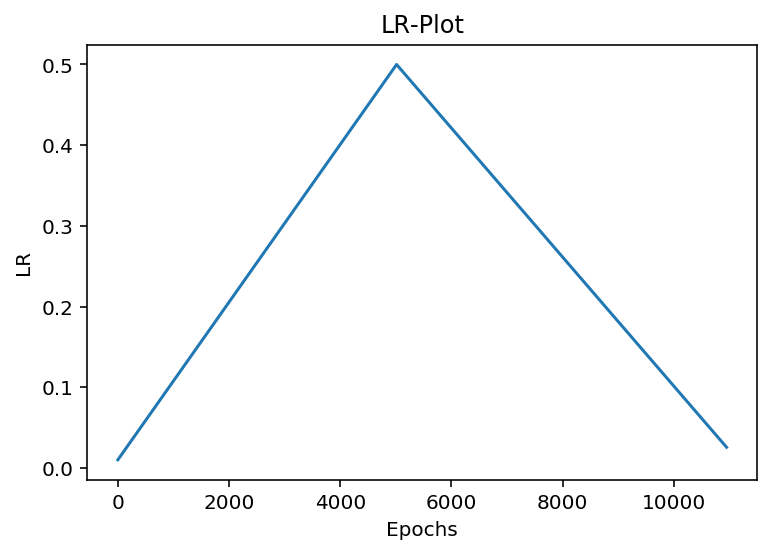

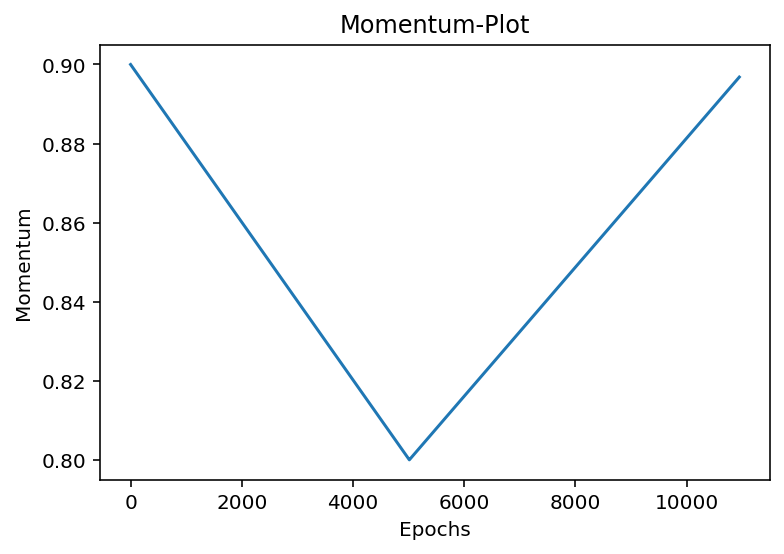

In [0]:
gc.collect()

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

olr = OneCycleLR(epochs=epochs, batch_size = batch_size,steps=len(train_iterator), 
                 samples=X_train.shape[0], max_lr=0.5, verbose = True, scale = 50, end_percentage=end_percentage,
                 maximum_momentum = 0.9, minimum_momentum=0.8, triangle_tilt=triangle_tilt)
callbacks=[olr,checkpoint,stopper]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)
olr.plot()


Observation
------------

The Model achieved > 90% accuracy with less than 30 epochs 
The model seems to over fit ( We will look into generalization later )


Cyclic Learning Rate
---------------------
This class has three built-in policies, "triangular": A basic triangular cycle w/ no amplitude scaling.

In [0]:
class CyclicLR(Callback):
   

    def __init__(self, base_lr=0.001, max_lr=0.05, step_size=2000., mode='exp_range',
                 scale_fn=None, scale_mode='cycle'):
				 
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        
        if scale_fn == None:
            
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
            print(' The learning rate used was ', self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())   
            print(' The learning rate used was ', self.clr())
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        #print(' The learning rate used was ', self.clr())
        
    def on_epoch_end(self, epoch, logs=None):
        print(" - lr: %0.5f " % (self.history['lr'][-1]))

In [0]:
inputs = Input(shape=(32,32,3))
model = build_resnet_model.build_model(inputs,model_type = 'resnet18')
optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy'])
print("Model Params = ",model.count_params(), ", Metric Names = ",model.metrics_names)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Filters in Resnet 18 = 64, Output Shape = (32, 32, 64)
Filters in Resnet 18 = 128, Output Shape = (16, 16, 128)
Filters in Resnet 18 = 256, Output Shape = (8, 8, 256)
Filters in Resnet 18 = 512, Output Shape = (4, 4, 512)
Final Shape  (10,)
Model Params =  11184768 , Metric Names =  ['loss', 'acc']


Model Training and Validation
--------------------------------
Define Image Data Generator for Validation

Save model checkpoint for best validation accuracy

Use the Custom Built Early Stopping function

Call Back using check point, Stopper and clr

Plot the Loss, Accuracy 


0

 The learning rate used was  0.001
Epoch 1/30
 79/391 [=====>........................] - ETA: 29s - loss: 2.6226 - acc: 0.4273 - lr: 0.01056 
Continue Training:: Val Acc = 0.427, Threshold = 0.900
391/391 [==============================] - 132s 339ms/step - loss: 2.6085 - acc: 0.3970 - val_loss: 2.6226 - val_acc: 0.4273
Epoch 2/30
 78/391 [====>.........................] - ETA: 26s - loss: 2.2829 - acc: 0.5163 - lr: 0.02013 
Continue Training:: Val Acc = 0.516, Threshold = 0.900
391/391 [==============================] - 122s 311ms/step - loss: 2.1521 - acc: 0.5675 - val_loss: 2.2823 - val_acc: 0.5161
Epoch 3/30
 78/391 [====>.........................] - ETA: 26s - loss: 2.2909 - acc: 0.5804 - lr: 0.02971 
Continue Training:: Val Acc = 0.580, Threshold = 0.900
391/391 [==============================] - 122s 311ms/step - loss: 1.8963 - acc: 0.6577 - val_loss: 2.2961 - val_acc: 0.5804
Epoch 4/30
 78/391 [====>.........................] - ETA: 26s - loss: 1.7812 - acc: 0.6971 - lr: 0.0392

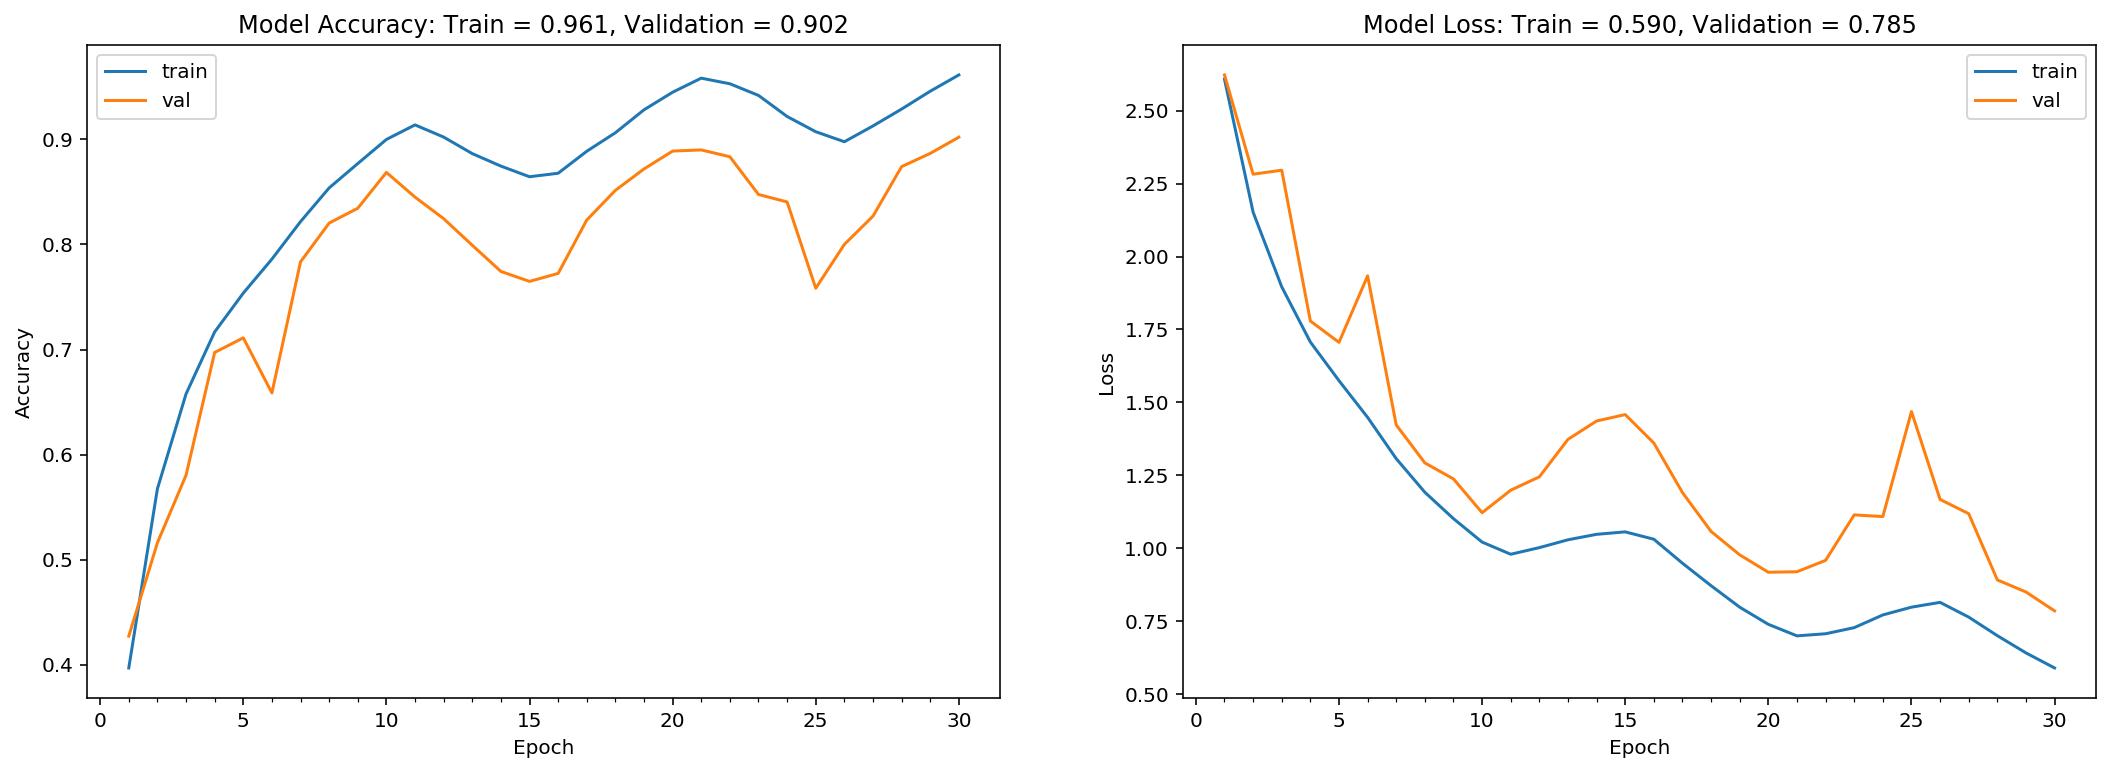

In [0]:
gc.collect()

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

cl = CyclicLR()
callbacks=[cl,checkpoint,stopper]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)
#olr.plot()


Observation
-----------
The model achieved > 90% accuracy on the 30th Epoch 

However the model still overfits


Fixed Learning Rate
---------------------

28

Epoch 1/30
391/391 [==============================] - 128s 326ms/step - loss: 2.4401 - acc: 0.4667 - val_loss: 2.3566 - val_acc: 0.4874
Epoch 2/30
391/391 [==============================] - 115s 295ms/step - loss: 2.0088 - acc: 0.6201 - val_loss: 2.0294 - val_acc: 0.6109
Epoch 3/30
391/391 [==============================] - 116s 295ms/step - loss: 1.7984 - acc: 0.6918 - val_loss: 1.8915 - val_acc: 0.6750
Epoch 4/30
391/391 [==============================] - 116s 296ms/step - loss: 1.6702 - acc: 0.7377 - val_loss: 1.7322 - val_acc: 0.7244
Epoch 5/30
391/391 [==============================] - 115s 295ms/step - loss: 1.5769 - acc: 0.7671 - val_loss: 1.9295 - val_acc: 0.6688
Epoch 6/30
391/391 [==============================] - 115s 295ms/step - loss: 1.5027 - acc: 0.7895 - val_loss: 1.5700 - val_acc: 0.7675
Epoch 7/30
391/391 [==============================] - 116s 295ms/step - loss: 1.4422 - acc: 0.8059 - val_loss: 1.5427 - val_acc: 0.7715
Epoch 8/30
391/391 [============================

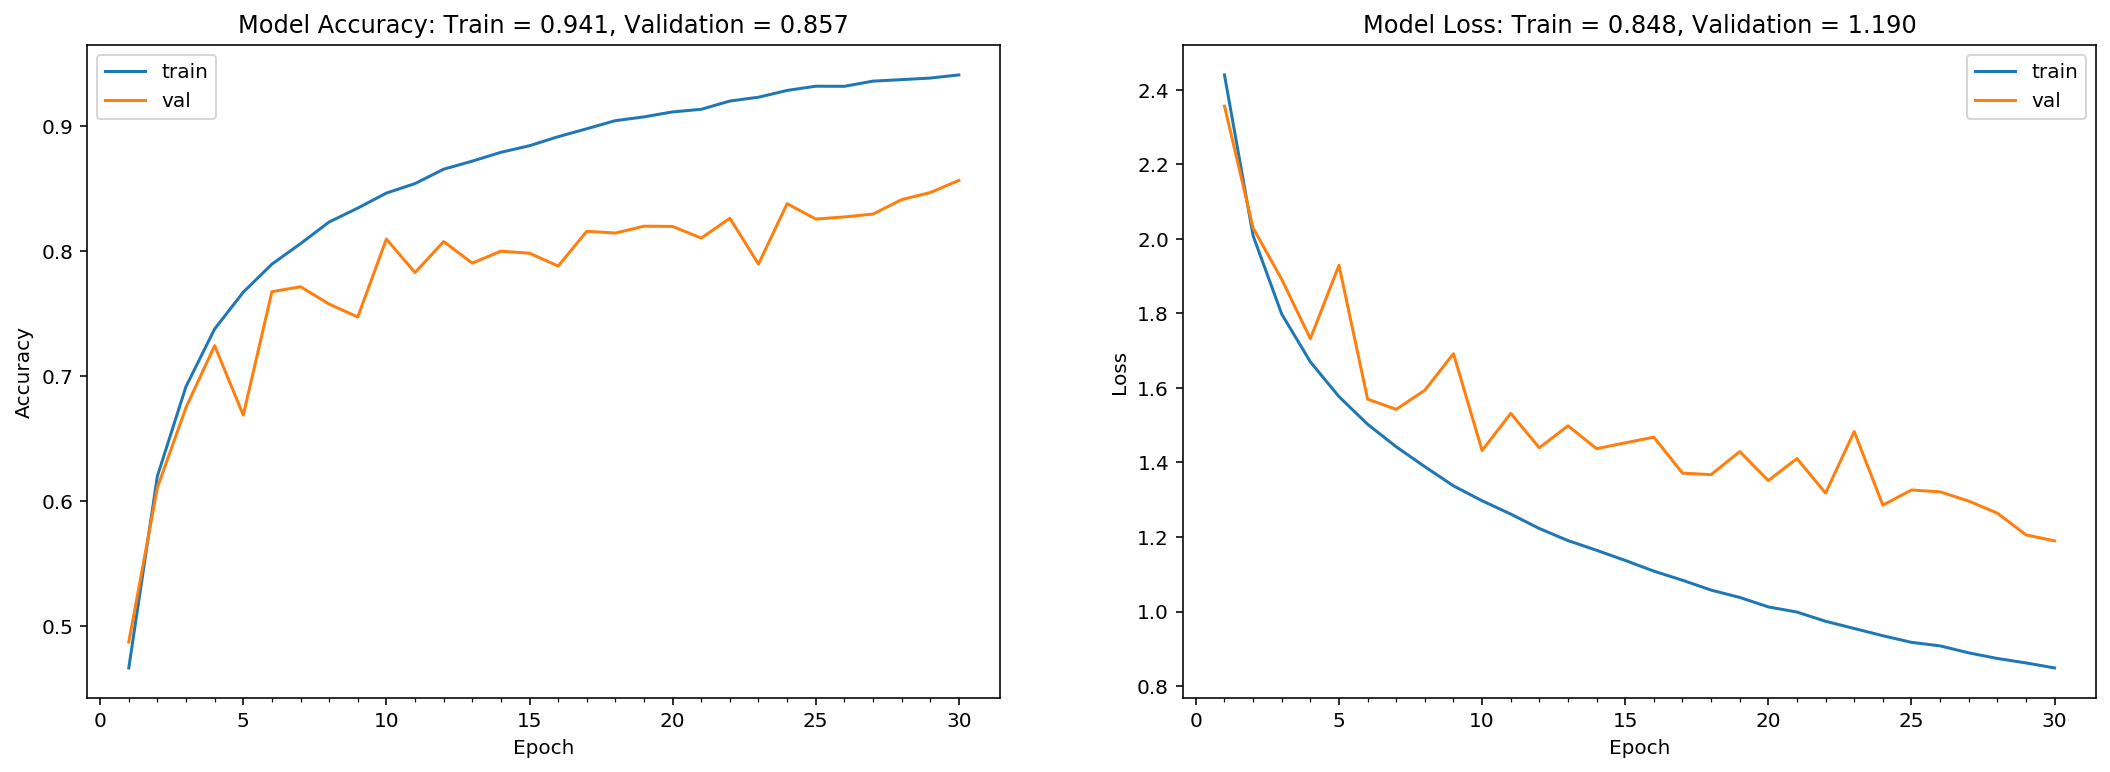

In [0]:
gc.collect()

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

#cl = CyclicLR()
callbacks=[checkpoint,stopper]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)
#olr.plot()

Observations
------------
The Model didn't achieve > 90% accuracy with in 30 epochs . I also ran it for 100 epochs but it still didn't achieve the required Accuracy


Cyclic Learning Rate 
---------------------
"triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.

In [0]:
class CyclicLR(Callback):
   

    def __init__(self, base_lr=0.001, max_lr=0.05, step_size=2000., mode='exp_range',
                 scale_fn=None, scale_mode='cycle'):
				 
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        
        if scale_fn == None:
            
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
            print(' The learning rate used was ', self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())   
            print(' The learning rate used was ', self.clr())
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        #print(' The learning rate used was ', self.clr())
        
    def on_epoch_end(self, epoch, logs=None):
        print(" - lr: %0.5f " % (self.history['lr'][-1]))

Model Training and Validation
--------------------------------
Define Image Data Generator for Validation

Save model checkpoint for best validation accuracy

Use the Custom Built Early Stopping function

Call Back using check point, Stopper and clr

Plot the Loss, Accuracy 


8863

 The learning rate used was  0.001
Epoch 1/30
 78/391 [====>.........................] - ETA: 25s - loss: 1.1778 - acc: 0.8590Continue Training:: Val Acc = 0.859, Threshold = 0.900
 - lr: 0.01056 
391/391 [==============================] - 117s 298ms/step - loss: 0.8066 - acc: 0.9558 - val_loss: 1.1791 - val_acc: 0.8589
Epoch 2/30
 78/391 [====>.........................] - ETA: 24s - loss: 1.5774 - acc: 0.7653Continue Training:: Val Acc = 0.766, Threshold = 0.900
 - lr: 0.02013 
391/391 [==============================] - 116s 297ms/step - loss: 0.8830 - acc: 0.9241 - val_loss: 1.5740 - val_acc: 0.7656
Epoch 3/30
 78/391 [====>.........................] - ETA: 25s - loss: 1.8897 - acc: 0.6977Continue Training:: Val Acc = 0.698, Threshold = 0.900
 - lr: 0.02971 
391/391 [==============================] - 116s 297ms/step - loss: 0.9873 - acc: 0.8862 - val_loss: 1.8939 - val_acc: 0.6978
Epoch 4/30
 78/391 [====>.........................] - ETA: 25s - loss: 1.6833 - acc: 0.7276Continue Trai

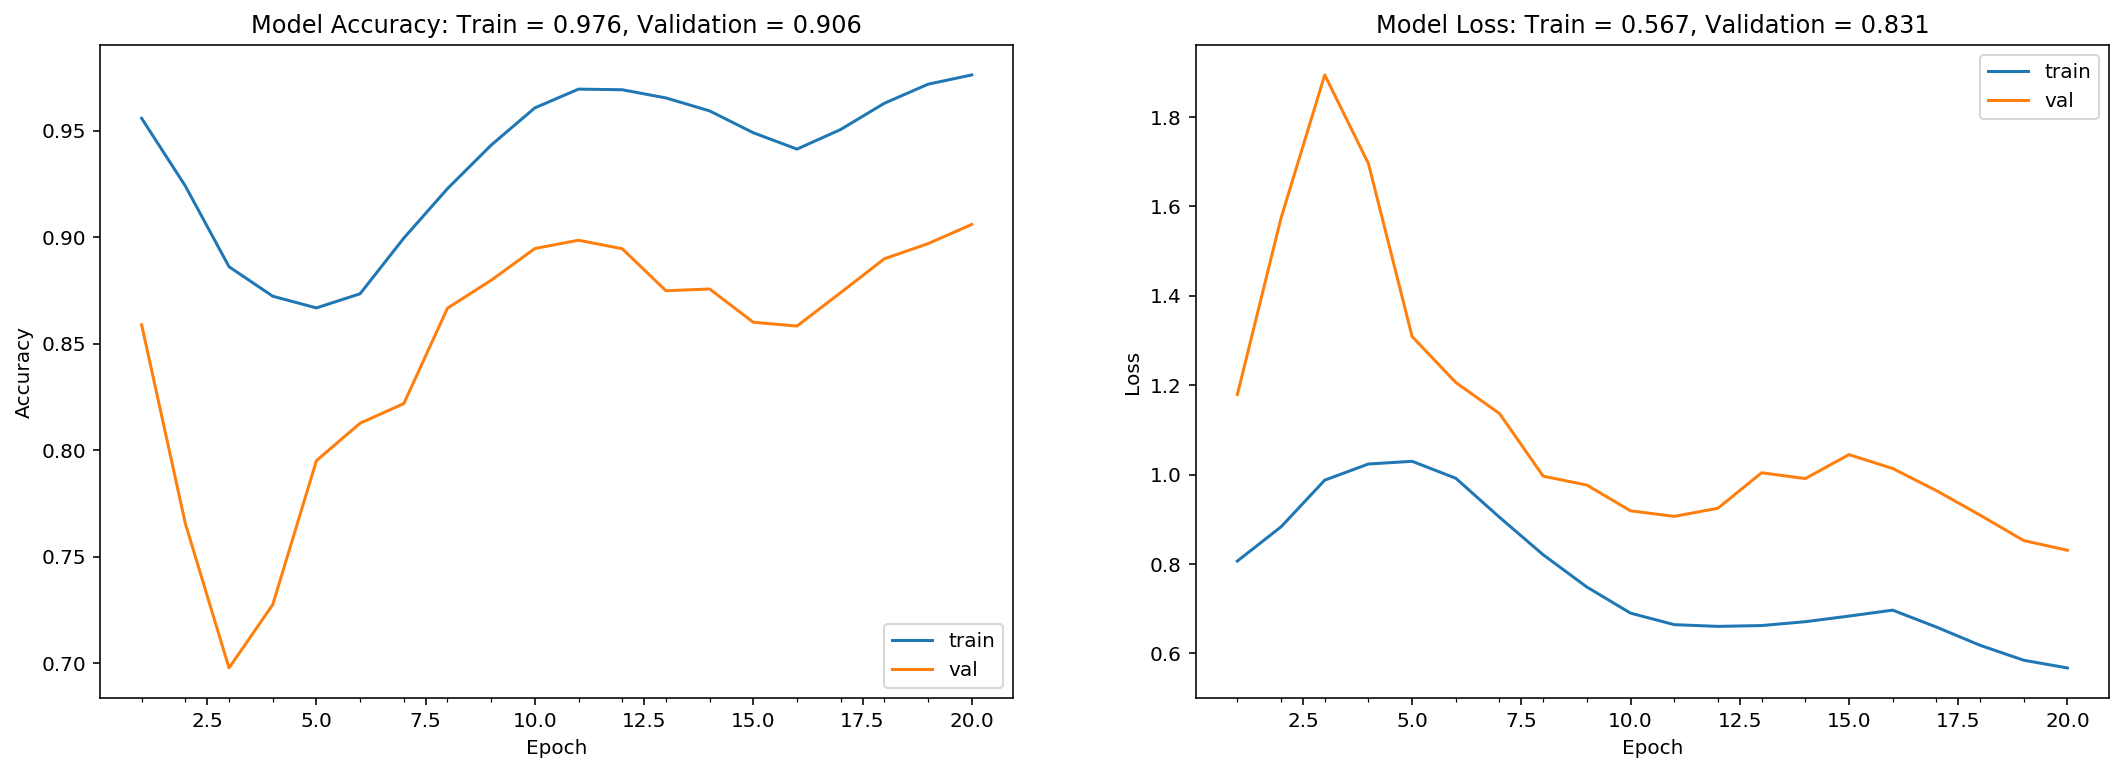

In [0]:
gc.collect()

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

cl1 = CyclicLR()
callbacks=[checkpoint,stopper,cl1]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)


Observations
--------------
The Model Achieved > 90% accuracy on the 20th Epoch 

However this model also overfits


Cyclic Learning Rate
---------------------
"exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each cycle iteration.

In [0]:
class CyclicLR(Callback):
   

    def __init__(self, base_lr=0.001, max_lr=0.05, step_size=2000., mode='exp_range',gamma=1.,
                 scale_fn=None, scale_mode='cycle'):
				 
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        
        if scale_fn == None:
            
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
            
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
            print(' The learning rate used was ', self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())   
            print(' The learning rate used was ', self.clr())
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        #print(' The learning rate used was ', self.clr())
        
    def on_epoch_end(self, epoch, logs=None):
        print(" - lr: %0.5f " % (self.history['lr'][-1]))

Model Training and Validation
------------------------------
Define Image Data Generator for Validation

Save model checkpoint for best validation accuracy

Use the Custom Built Early Stopping function

Call Back using check point, Stopper and clr

Plot the Loss, Accuracy

0

 The learning rate used was  0.001
Epoch 1/30
 79/391 [=====>........................] - ETA: 28s - loss: 2.6198 - acc: 0.4114Continue Training:: Val Acc = 0.411, Threshold = 0.900
 - lr: 0.01056 
391/391 [==============================] - 132s 337ms/step - loss: 2.6030 - acc: 0.4022 - val_loss: 2.6198 - val_acc: 0.4114
Epoch 2/30
 78/391 [====>.........................] - ETA: 25s - loss: 2.4862 - acc: 0.5109Continue Training:: Val Acc = 0.511, Threshold = 0.900
 - lr: 0.02013 
391/391 [==============================] - 120s 308ms/step - loss: 2.1294 - acc: 0.5747 - val_loss: 2.4943 - val_acc: 0.5111
Epoch 3/30
 78/391 [====>.........................] - ETA: 25s - loss: 2.0944 - acc: 0.6226Continue Training:: Val Acc = 0.623, Threshold = 0.900
 - lr: 0.02971 
391/391 [==============================] - 120s 308ms/step - loss: 1.8732 - acc: 0.6653 - val_loss: 2.0889 - val_acc: 0.6226
Epoch 4/30
 78/391 [====>.........................] - ETA: 26s - loss: 1.8980 - acc: 0.6581Continue Trai

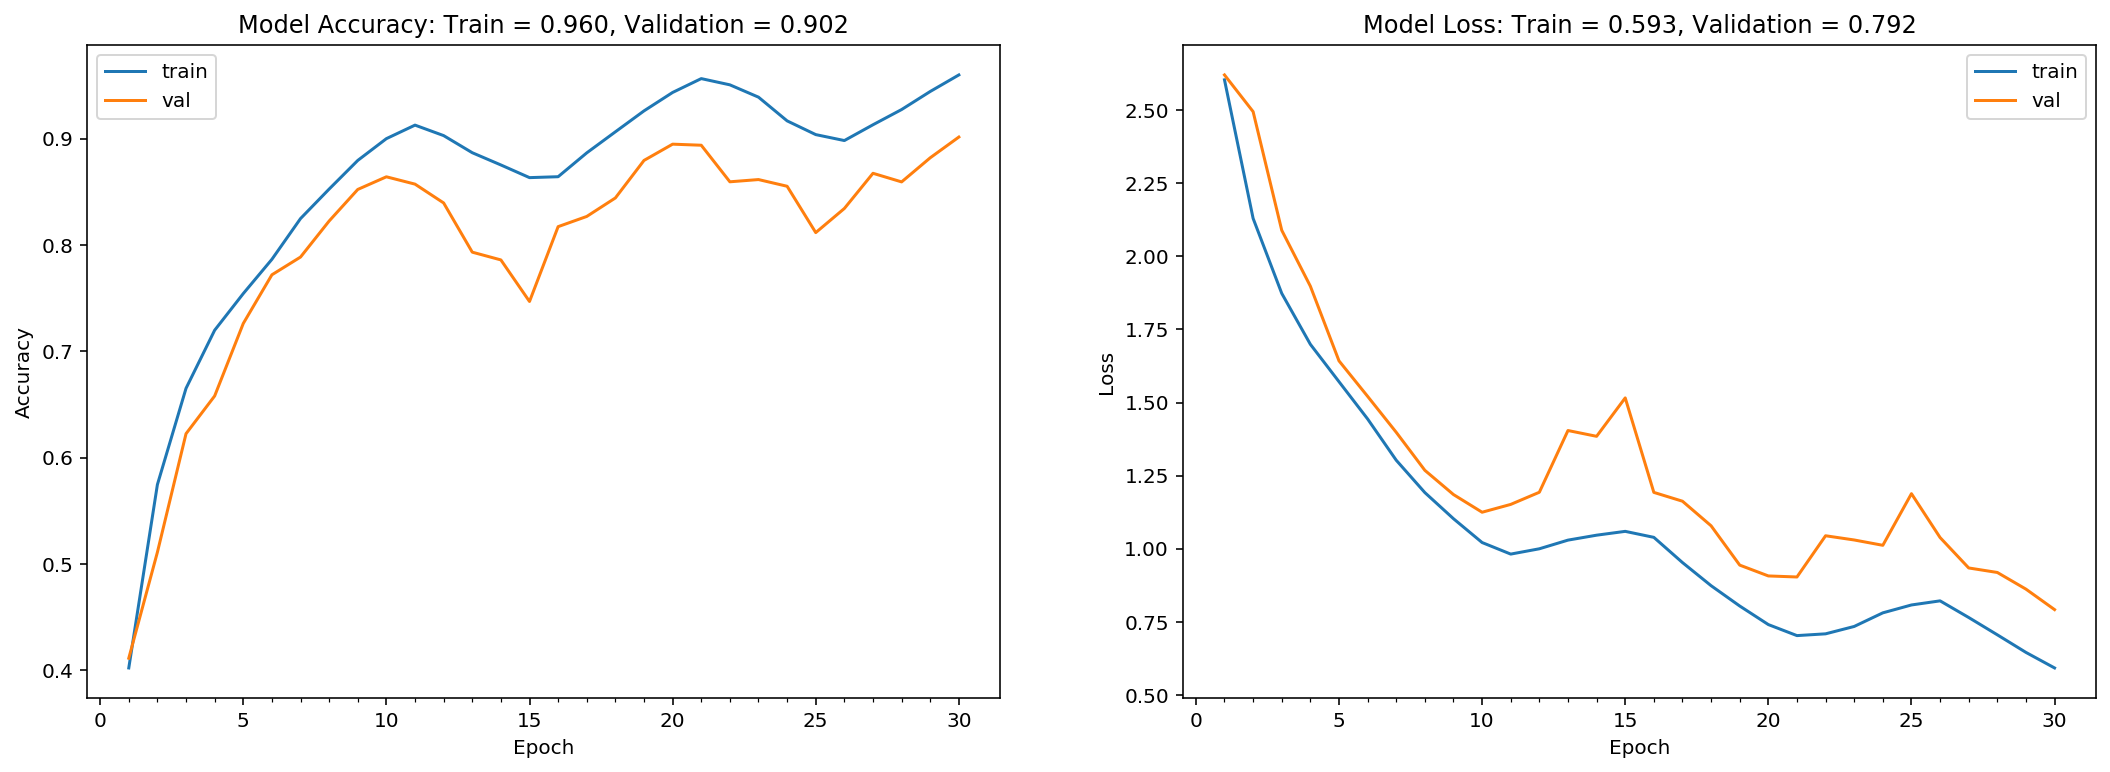

In [0]:
gc.collect()

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

cl2 = CyclicLR()
callbacks=[checkpoint,stopper,cl2]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)

Observation
------------
The Model achieved > 90% accuracy on 30th Epoch
However this model also overfits


Tried with 20 EPochs to see if it's reaching 90% Accuracy 
----------------------------------------------------------

0

 The learning rate used was  0.001
Epoch 1/20
 79/391 [=====>........................] - ETA: 27s - loss: 2.8452 - acc: 0.4285Continue Training:: Val Acc = 0.428, Threshold = 0.900
 - lr: 0.01056 
391/391 [==============================] - 127s 326ms/step - loss: 2.6136 - acc: 0.3964 - val_loss: 2.8452 - val_acc: 0.4285
Epoch 2/20
 78/391 [====>.........................] - ETA: 25s - loss: 2.2092 - acc: 0.5619Continue Training:: Val Acc = 0.562, Threshold = 0.900
 - lr: 0.02013 
391/391 [==============================] - 116s 296ms/step - loss: 2.1321 - acc: 0.5733 - val_loss: 2.2120 - val_acc: 0.5619
Epoch 3/20
 78/391 [====>.........................] - ETA: 25s - loss: 1.9287 - acc: 0.6521Continue Training:: Val Acc = 0.652, Threshold = 0.900
 - lr: 0.02971 
391/391 [==============================] - 116s 297ms/step - loss: 1.8702 - acc: 0.6656 - val_loss: 1.9281 - val_acc: 0.6520
Epoch 4/20
 78/391 [====>.........................] - ETA: 26s - loss: 2.1198 - acc: 0.6430Continue Trai

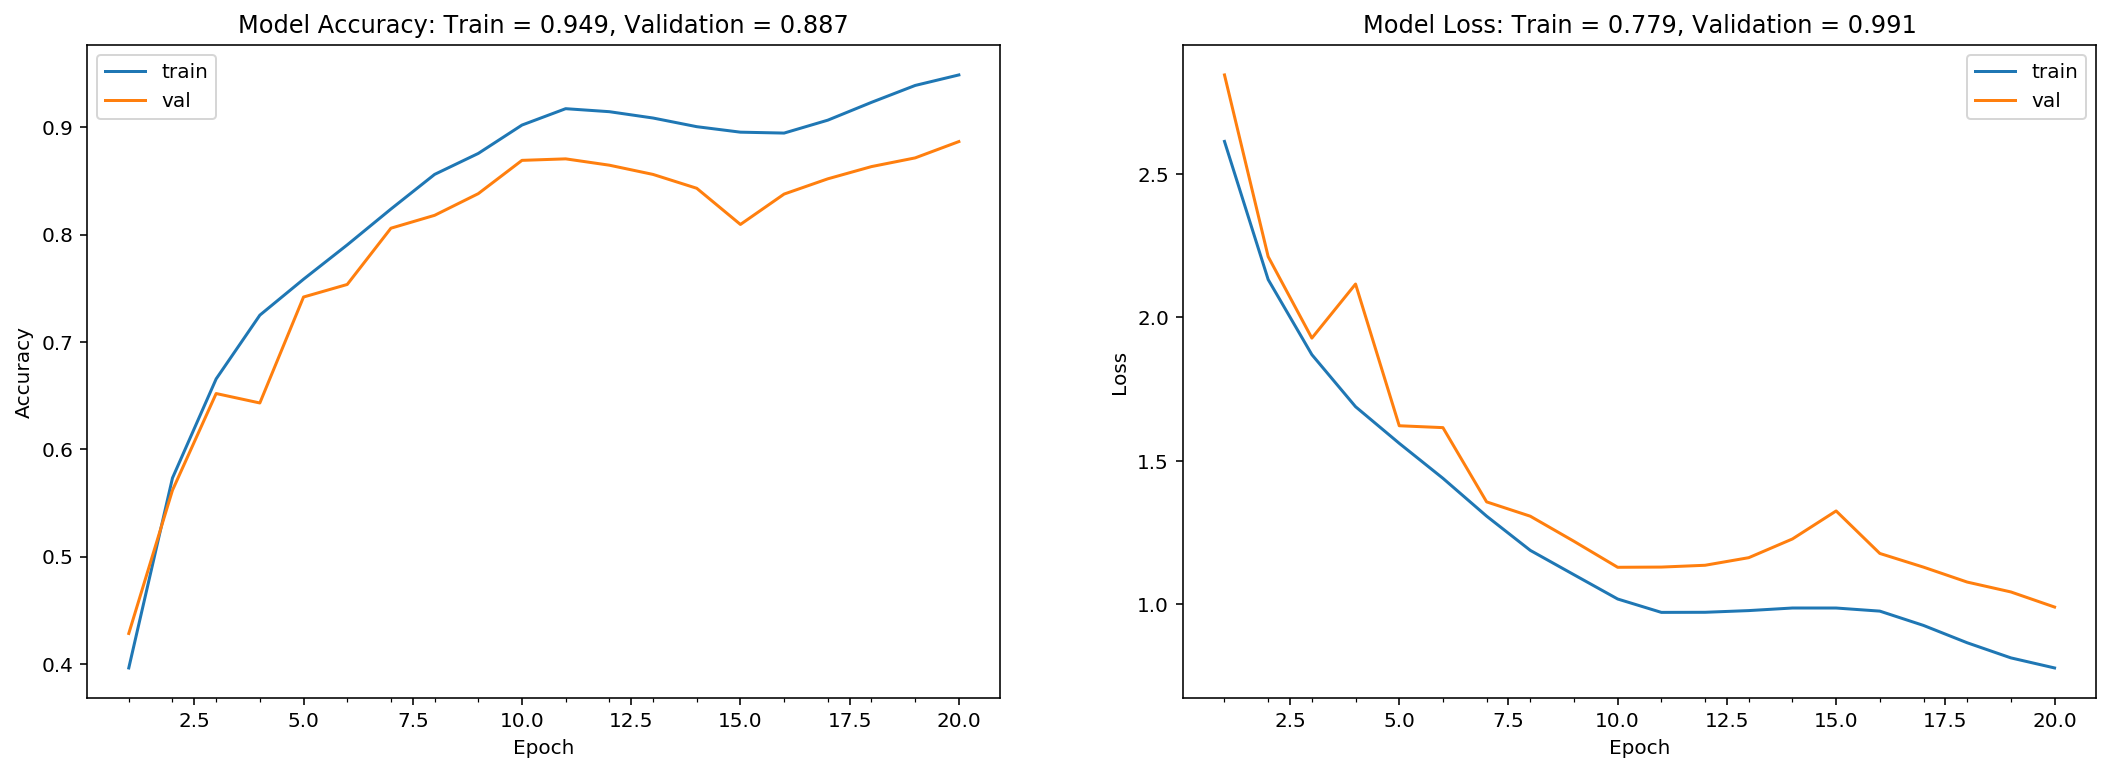

In [24]:
gc.collect()

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

cl3 = CyclicLR()
callbacks=[checkpoint,stopper,cl3]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)

Observations
------------------
The Model achieved 88.67% accuracy but still shows over fitting

Modified the Model and Parameters a bit
----------------------------------------
1. Used 7 x 7 as the first layer in the resnet18 model instead of 3 x 3
2. Changed the cutout probability as 0.5
3. Ran the Model for 100 epochs 


0

 The learning rate used was  0.001
Epoch 1/100
 79/391 [=====>........................] - ETA: 28s - loss: 5.9224 - acc: 0.3530Continue Training:: Val Acc = 0.353, Threshold = 0.900
 - lr: 0.01056 
391/391 [==============================] - 128s 328ms/step - loss: 5.7143 - acc: 0.3836 - val_loss: 5.9224 - val_acc: 0.3530
Epoch 2/100
 78/391 [====>.........................] - ETA: 25s - loss: 4.8088 - acc: 0.5450Continue Training:: Val Acc = 0.545, Threshold = 0.900
 - lr: 0.02013 
391/391 [==============================] - 117s 299ms/step - loss: 4.9957 - acc: 0.5519 - val_loss: 4.8139 - val_acc: 0.5447
Epoch 3/100
 78/391 [====>.........................] - ETA: 25s - loss: 4.5564 - acc: 0.5598Continue Training:: Val Acc = 0.560, Threshold = 0.900
 - lr: 0.02971 
391/391 [==============================] - 117s 299ms/step - loss: 4.2959 - acc: 0.6386 - val_loss: 4.5592 - val_acc: 0.5596
Epoch 4/100
 78/391 [====>.........................] - ETA: 25s - loss: 3.5986 - acc: 0.6232Continue 

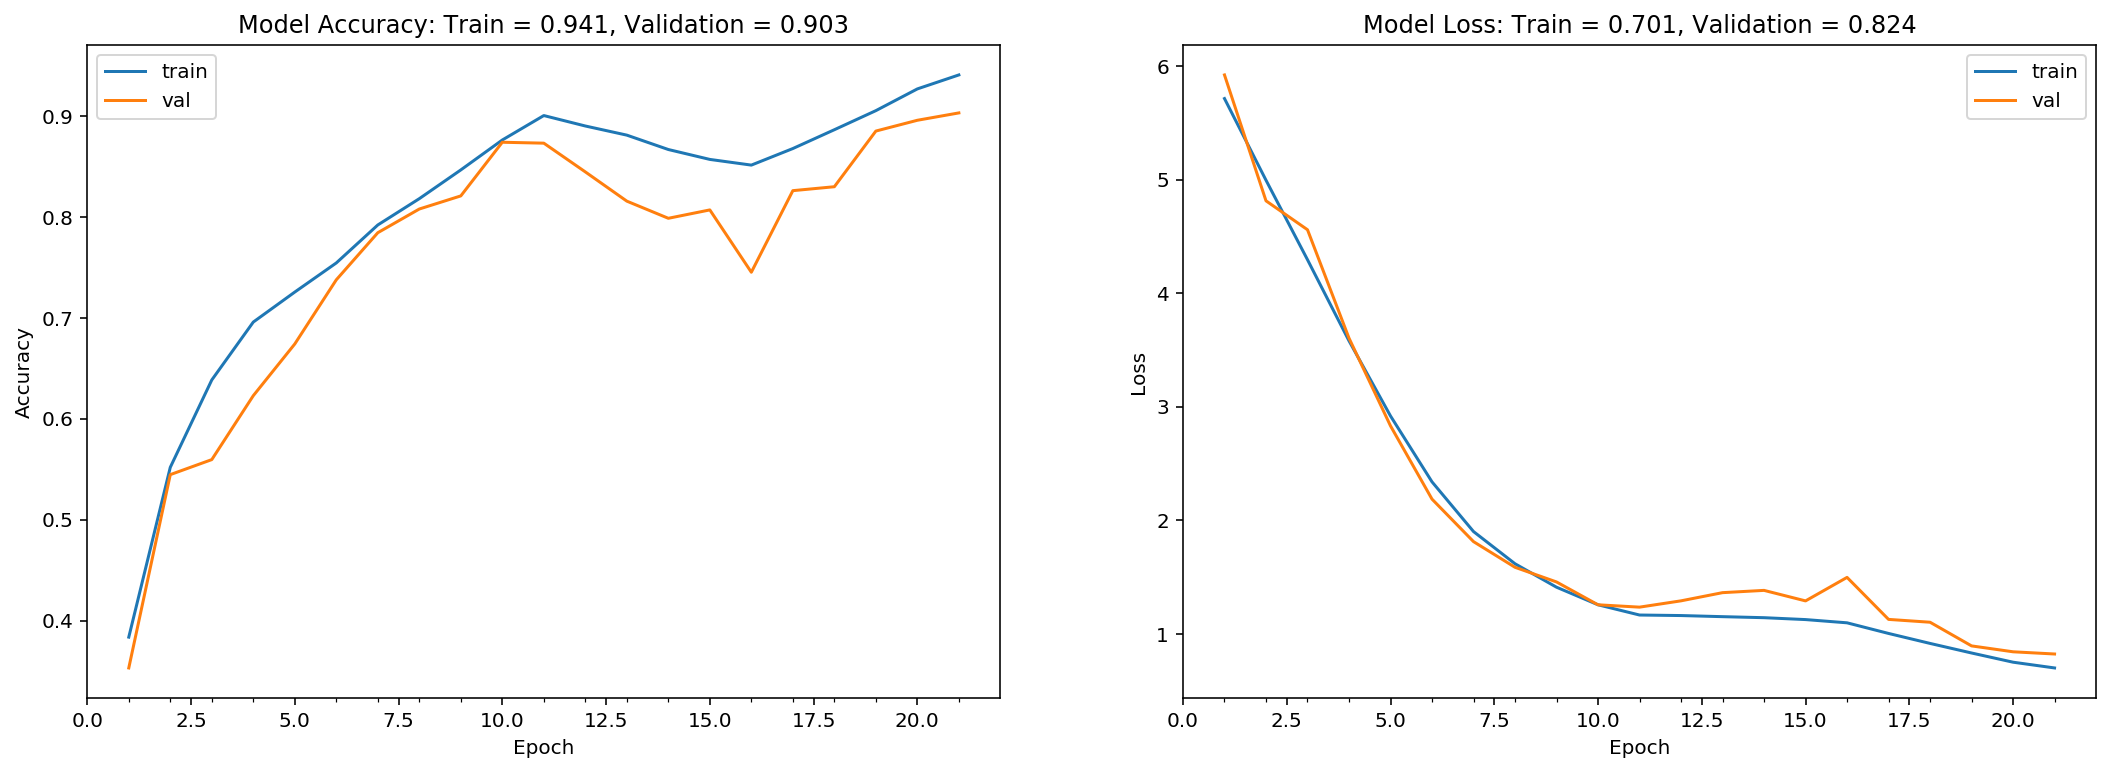

In [18]:
gc.collect()
from keras.callbacks import EarlyStopping
datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)
#es = EarlyStopping(monitor='val_acc', mode='max', baseline=0.7)

cl4 = CyclicLR()
callbacks=[checkpoint,stopper,cl4]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)

Observations
------------
The model achieved > 90% accuracy in 21st Epoch and seems to reduce the gap between training and validation accuracy a bit . Now let me run the model for 93% accuracy . I will try to run for 100 epochs 

7887

 The learning rate used was  0.001
Epoch 1/100
 78/391 [====>.........................] - ETA: 24s - loss: 1.1376 - acc: 0.8251Continue Training:: Val Acc = 0.825, Threshold = 0.930
 - lr: 0.01056 
391/391 [==============================] - 116s 296ms/step - loss: 0.7130 - acc: 0.9330 - val_loss: 1.1432 - val_acc: 0.8250
Epoch 2/100
 78/391 [====>.........................] - ETA: 24s - loss: 1.2144 - acc: 0.7976Continue Training:: Val Acc = 0.798, Threshold = 0.930
 - lr: 0.02013 
391/391 [==============================] - 116s 295ms/step - loss: 0.8104 - acc: 0.8949 - val_loss: 1.2177 - val_acc: 0.7975
Epoch 3/100
 78/391 [====>.........................] - ETA: 24s - loss: 1.2026 - acc: 0.7800Continue Training:: Val Acc = 0.780, Threshold = 0.930
 - lr: 0.02971 
391/391 [==============================] - 116s 296ms/step - loss: 0.8950 - acc: 0.8643 - val_loss: 1.1961 - val_acc: 0.7803
Epoch 4/100
 78/391 [====>.........................] - ETA: 24s - loss: 1.2370 - acc: 0.7735Continue 

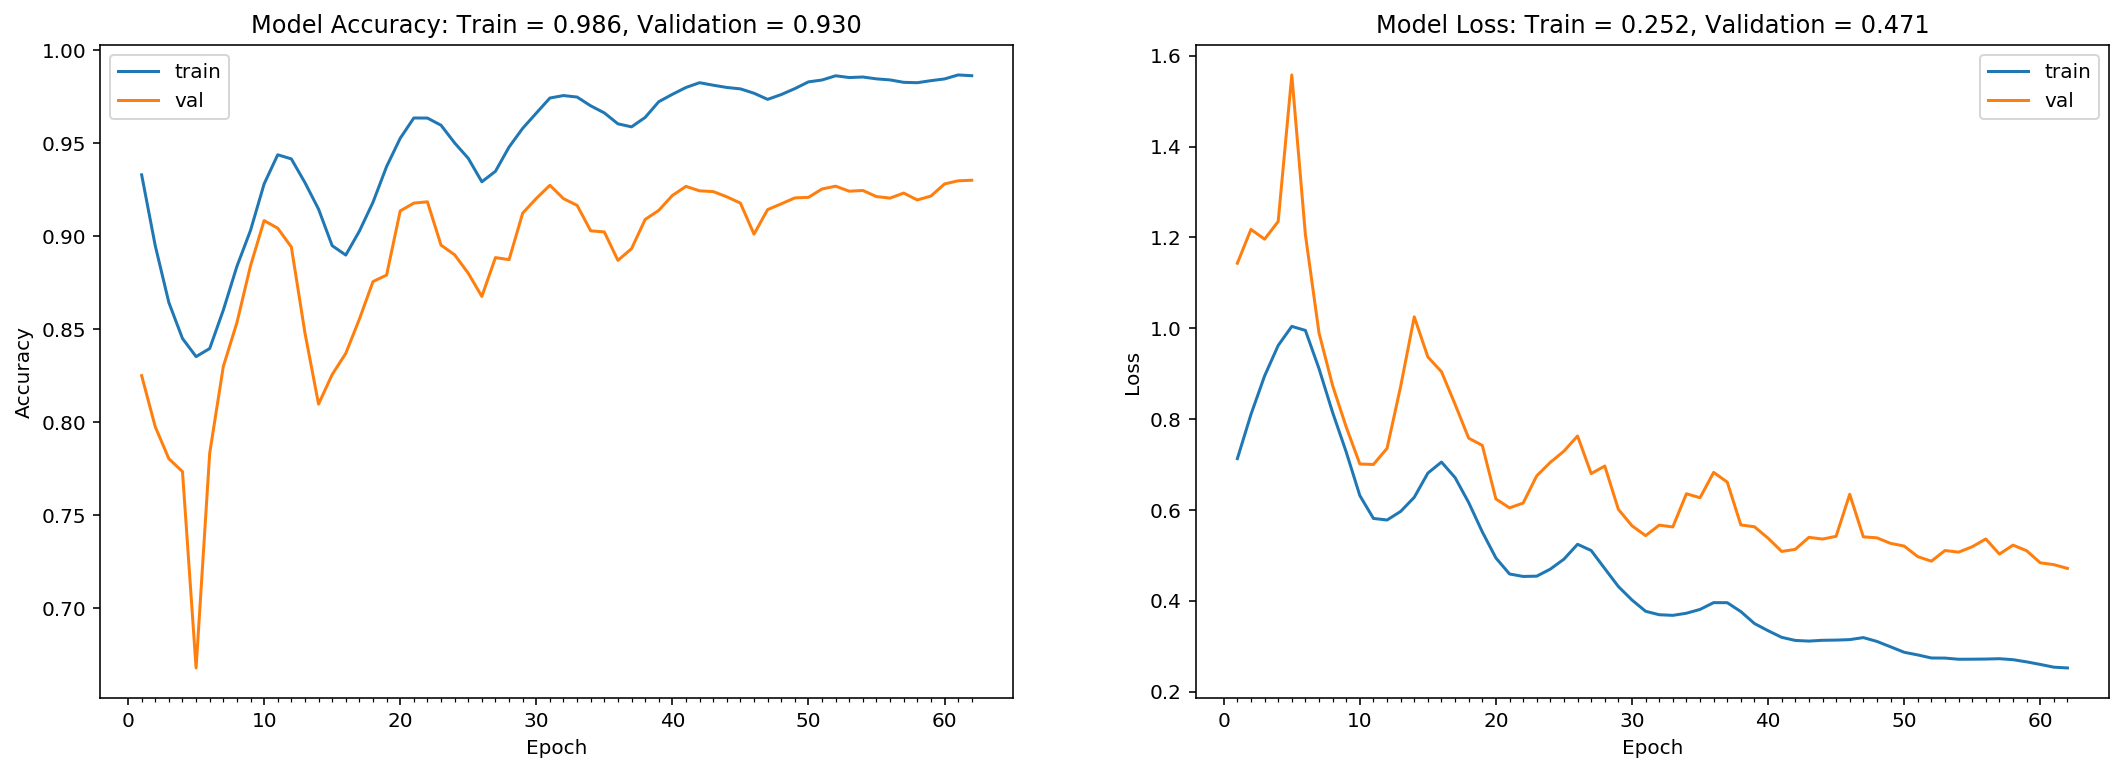

In [19]:
gc.collect()
from keras.callbacks import EarlyStopping
datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.93)
#es = EarlyStopping(monitor='val_acc', mode='max', baseline=0.7)

cl5 = CyclicLR()
callbacks=[checkpoint,stopper,cl5]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)

There we are ! Achieved > 93% accuracy below 100 epochs . Now i am excited . Planning to try for 94% accuracy . I may have to do a lot of parameter tuning for it and this assignment probably not looking for it , but nothing wrong in trying. Let me give it a shot 


In [0]:
gc.collect()
from keras.callbacks import EarlyStopping
datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.94)
#es = EarlyStopping(monitor='val_acc', mode='max', baseline=0.7)

cl6 = CyclicLR()
callbacks=[checkpoint,stopper,cl6]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = model_summary_helper.inspect_predictions(score, predictions,Y_test, classes=cifar_data.get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
model_summary_helper.plot_model_history(train_history,clip_beginning=0)

592

 The learning rate used was  0.001
Epoch 1/100
 78/391 [====>.........................] - ETA: 27s - loss: 0.8081 - acc: 0.9053Continue Training:: Val Acc = 0.905, Threshold = 0.940
 - lr: 0.01056 
391/391 [==============================] - 140s 357ms/step - loss: 0.5883 - acc: 0.9733 - val_loss: 0.8083 - val_acc: 0.9053
Epoch 2/100
 78/391 [====>.........................] - ETA: 27s - loss: 0.9794 - acc: 0.8645Continue Training:: Val Acc = 0.865, Threshold = 0.940
 - lr: 0.02013 
391/391 [==============================] - 136s 348ms/step - loss: 0.5638 - acc: 0.9718 - val_loss: 0.9769 - val_acc: 0.8646
Epoch 3/100
 78/391 [====>.........................] - ETA: 27s - loss: 1.2316 - acc: 0.7936Continue Training:: Val Acc = 0.794, Threshold = 0.940
 - lr: 0.02971 
391/391 [==============================] - 137s 349ms/step - loss: 0.5991 - acc: 0.9499 - val_loss: 1.2306 - val_acc: 0.7936
Epoch 4/100
 78/391 [====>.........................] - ETA: 27s - loss: 1.4399 - acc: 0.7490Continue 

My Colab Backend GPU again failed as i tried for 300 epochs . I will try to run it again after sometime and see how it works 
